In [3]:
import os
import random
import numpy as np
import tensorflow as tf

"""Assure la reproductibilité des résultats entre chaque run de l'autoencodeur et du MLP"""

seed = 42
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.config.experimental.enable_op_determinism()
tf.config.threading.set_inter_op_parallelism_threads(4)
tf.config.threading.set_intra_op_parallelism_threads(4)

print(f"Reproductibilité activée: seed={seed}")

Reproductibilité activée: seed=42


In [4]:
from tensorflow import keras
from keras import layers, models
import pyarrow as pa
import pyarrow.parquet as pq
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers,models,callbacks
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import InputLayer
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam
import pandas as pd
import requests
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, Normalizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import davies_bouldin_score,calinski_harabasz_score, silhouette_score
from sklearn.metrics import silhouette_samples
from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE
from umap import UMAP
from scipy.stats import ttest_ind
from scipy.stats import f_oneway
import time
from io import StringIO
from joblib import Parallel, delayed
import pickle
import networkx as nx

os.chdir(os.path.expanduser("~/projets/pro/BIP12: Artificial Intelligence"))    #Change as needed
print(f"Working Directory:\n{os.getcwd()}\n")
print(f"Keras version= {keras.__version__}")
print(f"Pandas version= {pd.__version__}")

#Ensure reproductibility
tf.config.experimental.enable_op_determinism()


Working Directory:
/home/pedro/projets/pro/BIP12: Artificial Intelligence

Keras version= 3.12.0
Pandas version= 2.3.3


# Chargement du fichier cohort pour les méta données, et des données patiens x gènes filtrées après QC

In [5]:
data_clean=pd.read_table("TCGA_IDC_ILC_Mixed.tsv")
data_cohort=pd.read_csv("clinical_metadata.csv")
print(f"Données chargées: {data_clean.shape}")
print(f"Méta données chargées: {data_cohort.shape}")

Données chargées: (646, 2001)
Méta données chargées: (817, 28)


In [6]:
data_clean = data_clean.rename(columns={"Unnamed: 0": "Case_ID"})
data_clean = data_clean.set_index("Case_ID")
print(data_clean.columns)

Index(['MT-RNR2', 'CPB1', 'RN7SL1', 'MT-CO1', 'IGHG1', 'COL1A1', 'MT-ND4',
       'IGKC', 'SCGB2A2', 'COL1A2',
       ...
       'MEX3A', 'SOGA1', 'FLOT2', 'FRMD6', 'ECEL1', 'AMIGO2', 'CGN', 'NAXE',
       'LLGL2', 'SMG1'],
      dtype='object', length=2000)


In [7]:
# 1. IDs à garder (tout sauf Mixed.IDC.ILC)
ids_to_keep = data_cohort.loc[
    data_cohort["Final Pathology"] != "Mixed.IDC.ILC",
    "Case_ID"
]
# 2. Filtrer data_clean avec ces IDs
data_clean_filtered = data_clean.loc[
    data_clean.index.isin(ids_to_keep)
]
print(f"Shape avant: {data_clean.shape}")
print(f"Shape après: {data_clean_filtered.shape}")


Shape avant: (646, 2000)
Shape après: (558, 2000)


In [23]:
# Vérifier d'abord les vrais noms des colonnes dans df
metadata_cols = ["TumorPurity", "Final Pathology", "ProliferationScore",'PAM50']

# Créer une dataframe avec les métadonnées, indexée par Case_ID
metadata = data_cohort[['Case_ID'] + metadata_cols].set_index('Case_ID')

test_matrix_with_meta = data_clean_filtered.copy()
test_matrix_with_meta = test_matrix_with_meta.join(metadata, how='left')

print(f"\nColonnes des méta données à ajouter:\n{metadata_cols}")
print(f"\nShape avant l'ajout des méta données: {data_clean_filtered.shape}")
print(f"Shape après l'ajout des méta données: {test_matrix_with_meta.shape}\n")
print(test_matrix_with_meta.iloc[:, -5:].head())
print(test_matrix_with_meta.columns)


Colonnes des méta données à ajouter:
['TumorPurity', 'Final Pathology', 'ProliferationScore', 'PAM50']

Shape avant l'ajout des méta données: (558, 2000)
Shape après l'ajout des méta données: (558, 2004)

                  SMG1  TumorPurity Final Pathology  ProliferationScore  PAM50
Case_ID                                                                       
TCGA-BH-A18G -1.724484         0.79             IDC            0.423067  Basal
TCGA-A1-A0SP  0.403568         0.46             IDC            0.262933  Basal
TCGA-A2-A04P -1.120306         0.60             IDC            0.445335  Basal
TCGA-A2-A04Q -0.526570         0.17             IDC            0.189018  Basal
TCGA-A2-A04T  0.102360         0.61             IDC            0.376498  Basal
Index(['MT-RNR2', 'CPB1', 'RN7SL1', 'MT-CO1', 'IGHG1', 'COL1A1', 'MT-ND4',
       'IGKC', 'SCGB2A2', 'COL1A2',
       ...
       'ECEL1', 'AMIGO2', 'CGN', 'NAXE', 'LLGL2', 'SMG1', 'TumorPurity',
       'Final Pathology', 'ProliferationScore'

In [10]:
print(metadata_cols)
test_matrix_with_meta.shape

['TumorPurity', 'Final Pathology', 'ProliferationScore', 'PAM50']


(646, 2004)

In [25]:
Target = "PAM50"    #Changer pour modifier le target pour les prédictions, ici on prédit les classes de PAM50

y_text = test_matrix_with_meta[Target]
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y_text)
y_cat = to_categorical(y)

print(f"Classes: {label_encoder.classes_}")
print(f"Forme y_cat: {y_cat.shape}")

"""Paramètres"""
T = 0.3
seed = 42

def stratified_split(X, y, test_size=0.3, random_state=42):
    """Fonction pour faire le split des données train/test  
    avec stratification des indices pour reproductibilité complète.\n
    ### Paramètres: 
    - test_size: int (pourcentage du split entre train et test)
    - random_state: seed pour le RNG, assure la reproductibilité\n
    ### Output: 
    - X_train, X_test, y_train, y_test: données splitées
    - train_indices, test_indices: indices du split pour vérifier la reproductibilité
    """ 
    train_indices, test_indices = train_test_split(
        np.arange(len(X)),
        test_size=test_size,
        random_state=random_state,
        stratify=y
    )
    
    X_train, X_test = X.iloc[train_indices], X.iloc[test_indices]
    Y_train, Y_test = y[train_indices], y[test_indices]
    
    return X_train, X_test, Y_train, Y_test, train_indices, test_indices

"""Utilisation du split stratifié"""

X_train, X_test, Y_train, Y_test, train_index, test_index = stratified_split(
    data_clean_filtered, 
    y,
    test_size=T, 
    random_state=seed
)
print(f"\nColonne cible pour la prédiction: {Target}\n")
print(f"    Indices d'entraînement: {train_index[:10]}...")
print(f"    Indices de test: {test_index[:10]}...")
print(f"\n    Distribution train: {len(Y_train)}/{len(y)} ({100*len(Y_train)/len(y):.1f}%)")
print(f"    Distribution test: {len(Y_test)}/{len(y)} ({100*len(Y_test)/len(y):.1f}%)")

Classes: ['Basal' 'Her2' 'LumA' 'LumB' 'Normal']
Forme y_cat: (558, 5)

Colonne cible pour la prédiction: PAM50

    Indices d'entraînement: [116 514 427  26  88 451 319 208 371 335]...
    Indices de test: [147 481 318  96 340 519 325 261 344 145]...

    Distribution train: 390/558 (69.9%)
    Distribution test: 168/558 (30.1%)


In [26]:
"""Vérifying splits"""
print("Debugging:\n")
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")

Debugging:

Shape of X_train: (390, 2000)
Shape of X_test: (168, 2000)


## Clustering: NN approach to the number of clusters

Deploy a simple NN and have as an output the optimal nomber of clusters for the dataset, and then apply it to another NN which will handle the clustering itself
# Network class
This class has: 
- autoencoder module: fully modular
- latent space encoding
- MLP module: fully modular

This following cell defines the network class, in order to use it refer to the next cell, names "Using the network class"

In [27]:
class RNASeqNetwork:
    """
    Classe centralisée pour gérer les réseaux de neurones sur données RNAseq
    - Autoencoder pour réduction de dimensionalité
    - Clustering dans l'espace latent
    - MLP pour classification
    """
    
    def __init__(self, input_dim, seed=42):
        """
        input_dim : int
            Nombre de features en entrée
        seed : int
            Seed pour reproductibilité
        """
        self.input_dim = input_dim
        self.seed = seed
        self.encoder = None
        self.autoencoder = None
        self.mlp_classifier = None
        self.history = {}
        self.X_encoded = None
        self.labels = None
        self.n_clusters = None
        
        # Fixer les seeds
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
        tf.config.experimental.enable_op_determinism()
        
        print(f"Network (input_dim={input_dim}, seed={seed})")
    
    
    def build_autoencoder(self, encoding_dim=30, hidden_layers=[128, 64],activation='relu', dropout_rate=0.2):
        """## Construit l'autoencoder:\n
        - Encoding_dim: taille du latent space,\n
        - hidden_layers: nombre de layers et de neurones par layers dans chaque côté du AE,\n
        - activation: fonction d'activation (sigmoid,softmax,linear,relu),\n
        - dropout_rate: proportion de neurones inactivés (previens overfitting)
        """
        
        # Encoder side
        input_layer = keras.layers.Input(shape=(self.input_dim,), name='input')
        x = input_layer
        
        for i, units in enumerate(hidden_layers):
            x = keras.layers.Dense(units, activation=activation, name=f'enc_dense_{i}')(x)
            if dropout_rate > 0:
                x = keras.layers.Dropout(dropout_rate, name=f'enc_dropout_{i}')(x)
        
        # Latent space (encoding_dim)
        encoding = keras.layers.Dense(encoding_dim, activation=activation, name='encoding')(x)
    
        # Decoder side
        x = encoding
        
        for i, units in enumerate(reversed(hidden_layers)):
            x = keras.layers.Dense(units, activation=activation, name=f'dec_dense_{i}')(x)
            if dropout_rate > 0:
                x = keras.layers.Dropout(dropout_rate, name=f'dec_dropout_{i}')(x)
        
        # Reconstruction
        output_layer = keras.layers.Dense(self.input_dim, activation='linear', name='output')(x)
        
        # Assemblage
        self.autoencoder = keras.Model(inputs=input_layer, outputs=output_layer, name='autoencoder')
        self.encoder = keras.Model(inputs=input_layer, outputs=encoding, name='encoder')
        
        print(f"Autoencoder construit: {self.input_dim} → {' → '.join(map(str, hidden_layers))} → {encoding_dim}")
        
        return self
    
    
    def train_autoencoder(self, X_train, epochs=50, batch_size=32,validation_split=0.2, learning_rate=0.001, verbose=1):
        """## Entraîne l'autoencoder\n
        Paramètres:
        - X_train : array-like (Données d'entraînement)
        - epochs : int (Nombre d'itérations)
        - batch_size : int (Taille des batchs)
        - validation_split : float (Proportion de validation)
        - learning_rate : float (Taux d'apprentissage)
        """
        seed=42
        tf.config.experimental.enable_op_determinism()
        random.seed(seed)
        os.environ['PYTHONHASHSEED'] = str(seed)

        if self.autoencoder is None:
            raise ValueError("Autoencoder non construit. Utilisez build_autoencoder() d'abord.")
        
        self.autoencoder.compile(
            optimizer=Adam(learning_rate=learning_rate),
            loss='mse',
            metrics=['mse']
        )
        
        callbacks = [
            EarlyStopping(
                monitor='val_loss',
                patience=25,
                restore_best_weights=True,
                verbose=1
            ),
            ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.2,
                patience=10,
                min_lr=1e-7,
                verbose=1
            )
        ]
        
        print(f"Entraînement autoencoder ({epochs} epochs max, batch={batch_size})")
        
        self.history['autoencoder'] = self.autoencoder.fit(
            X_train, X_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_split=validation_split,
            callbacks=callbacks,
            verbose=verbose
        )
        
        print(f"Entraînement terminé (loss finale: {self.history['autoencoder'].history['val_loss'][-1]:.4f})")
        
        return self
    
    def plot_ae_networkx(self,layer_sizes=None,layer_names=None, max_nodes_per_layer=10,node_size=220,edge_alpha=0.18,title="Architecture de l'autoencodeur"):
        """
        Dessine une architecture d'autoencodeur en utilisant networkX.
        
        Paramètres:
        - layer_sizes : tuple, optional
            Tailles réelles des couches. Si None, extrait de l'autoencoder.
        - layer_names : tuple, optional
            Noms des couches pour affichage
        - max_nodes_per_layer : int
            Nombre max de neurones à dessiner par couche
        - node_size : int
            Taille des nœuds
        - edge_alpha : float
            Transparence des arêtes
        - title : str
            Titre du graphique
        """
        #-----------------------------------------------
        MIN_NODES = 4                  # nb min de noeuds affichés au latent
        MAX_NODES = max_nodes_per_layer  # nb max affiché aux extrémités
        #-----------------------------------------------

        # Extraire automatiquement les tailles si non fournies
        if layer_sizes is None:
            if self.autoencoder is None:
                raise ValueError("Autoencoder non construit. Construisez-le d'abord ou fournissez layer_sizes.")
            
            layer_sizes = [self.input_dim]
            for layer in self.autoencoder.layers:
                if hasattr(layer, 'units'):
                    layer_sizes.append(layer.units)
            layer_sizes = tuple(layer_sizes)
        
        # Noms par défaut si non fournis
        if layer_names is None:
            layer_names = [f"Layer {i}" for i in range(len(layer_sizes))]
        
        rng = np.random.default_rng(self.seed)
        
        def display_count(n):
            return int(min(max_nodes_per_layer, max(3, round(np.sqrt(n))))) if n > max_nodes_per_layer else int(n)

        latent_idx = layer_names.index("Latent") if "Latent" in layer_names else (len(layer_sizes) // 2)
        max_dist = max(latent_idx, (len(layer_sizes) - 1) - latent_idx)

        def n_vis_for_layer(li: int) -> int:
            d = abs(li - latent_idx)
            t = d / max_dist if max_dist > 0 else 0.0  
            n = int(round(MIN_NODES + (MAX_NODES - MIN_NODES) * (t**1.6)))
            return int(min(layer_sizes[li], max(3, n)))
        disp = [n_vis_for_layer(li) for li in range(len(layer_sizes))]
            
        G = nx.DiGraph()
        pos = {}
        node_layer = {}
        x_spacing = 2.2
        y_spacing = 1.0
        
        # Créer les nœuds pour chaque layer
        for li, (n_real, n_vis) in enumerate(zip(layer_sizes, disp)):
            x = li * x_spacing
            ys = np.linspace(-(n_vis - 1) / 2, (n_vis - 1) / 2, n_vis) * y_spacing
            
            show_ellipsis = (n_real > n_vis)
            
            if show_ellipsis and n_vis >= 6:
                idxs = list(range(n_vis))
                ellipsis_idx = n_vis // 2
            else:
                idxs = list(range(n_vis))
                ellipsis_idx = None
            
            for j in idxs:
                nid = f"L{li}_N{j}"
                G.add_node(nid)
                pos[nid] = (x, ys[j])
                node_layer[nid] = li
            
            # Ajouter marqueur ellipsis si nécessaire
            if show_ellipsis and ellipsis_idx is not None:
                eid = f"L{li}_ELLIPSIS"
                G.add_node(eid)
                pos[eid] = (x, ys[ellipsis_idx])
                node_layer[eid] = li
        
        # Connecter les layesr
        for li in range(len(layer_sizes) - 1):
            left_nodes = [n for n in G.nodes if node_layer.get(n) == li and not n.endswith("ELLIPSIS")]
            right_nodes = [n for n in G.nodes if node_layer.get(n) == li + 1 and not n.endswith("ELLIPSIS")]
            for a in left_nodes:
                for b in right_nodes:
                    G.add_edge(a, b)
        
        fig, ax = plt.subplots(figsize=(14, 4.8))
        ax.set_axis_off()

        layer_colors = []
        latent_idx = len(layer_sizes) // 2 
        for li in range(len(layer_sizes)):
            if li == latent_idx:
                layer_colors.append("lightgray") 
            else:
                layer_colors.append("white")
        
        nx.draw_networkx_edges(
            G, pos, ax=ax,
            arrows=False,
            alpha=edge_alpha,
            width=0.8
        )

        MIN_SIZE = 25      # taille au latent
        MAX_SIZE = 90      # taille aux extrémités (input/output)

        def node_size_for_layer(li: int) -> float:
            d = abs(li - latent_idx)             
            t = d / max_dist if max_dist > 0 else 0.0  
            return MIN_SIZE + (MAX_SIZE - MIN_SIZE) * t

        for li in range(len(layer_sizes)):
            nodes_li = [n for n in G.nodes if node_layer.get(n) == li and not n.endswith("ELLIPSIS")]

            nx.draw_networkx_nodes(
                G, pos,
                nodelist=nodes_li,
                node_size=node_size_for_layer(li),
                node_color="teal",
                ax=ax
            )
            
            # Ellipsis nodes
            ellipsis_nodes = [n for n in G.nodes if node_layer.get(n) == li and n.endswith("ELLIPSIS")]
            if ellipsis_nodes:
                nx.draw_networkx_labels(
                    G, pos,
                    labels={n: "⋮" for n in ellipsis_nodes},
                    font_size=20,
                    ax=ax
                )
        
        # Labels au-dessus de chaque couche
        y_top = max(y for _, y in pos.values()) + 1.2
        for li, (name, n_real) in enumerate(zip(layer_names, layer_sizes)):
            x = li * x_spacing
            ax.text(x, y_top, f"{name}\n({n_real})", 
                    ha="center", va="bottom", fontsize=11, fontweight="bold")
        
        # Titre
        ax.text((len(layer_sizes) - 1) * x_spacing / 2,
            y_top + 4.0,
            title,
            ha="center",
            va="bottom",
            fontsize=15,
            fontweight="bold"
        )
        
        # Limites
        xs = [p[0] for p in pos.values()]
        ys = [p[1] for p in pos.values()]
        ax.set_xlim(min(xs) - 1.0, max(xs) + 1.0)
        ax.set_ylim(min(ys) - 4.5, y_top + 2.0)
        
        plt.tight_layout()
        plt.show()


    def encode_data(self, X):
        """### Encode les données dans l'espace latent\n
        Renvoie les données encodées si on veut utiliser uniquement l'encodeur
        #### Parameters:
        - X : array-like (Données à encoder)\n
        #### Return:
        - X_encoded : array (Données encodées)
        """
        if self.encoder is None:
            raise ValueError("Encoder non construit")
        
        self.X_encoded = self.encoder.predict(X, verbose=0)
        print(f"Données encodées: {X.shape} → {self.X_encoded.shape}")
        
        return self.X_encoded
    
    
    def evaluate_clustering(self, X_encoded=None, max_clusters=20):
        """### Évalue plusieures métriques pour trouver le nombre optimal de clusters\n
        Utilise les métriques suivantes: 
        - Silhouette score
        - Davies-Bouldin
        - Calinski-Harabasz
        - Elbow method
        #### Paramètres: 
        - X_encoded : array-like, optional (Données encodées)
        - max_clusters : int
            (Nombre maximale de clusters à tester)
        #### Output: 
        - df_metrics : pd.DataFrame
            (Dataframe avec toutes les scores par nombre de clusters)
        """    
        if X_encoded is None:
            X_encoded = self.X_encoded
        
        if X_encoded is None:
            raise ValueError("Pas de données encodées. Utilisez encode_data() d'abord.")
        
        K_range = range(2, min(max_clusters + 1, len(X_encoded)))
        metrics_results = {
            'n_clusters': [],
            'silhouette': [],
            'davies_bouldin': [],
            'calinski_harabasz': [],
            'Elbow': []
        }
        
        print(f"Évaluation de {len(K_range)} configurations de clusters")
        
        for k in K_range:
            kmeans = KMeans(n_clusters=k, random_state=self.seed, n_init=10)
            labels = kmeans.fit_predict(X_encoded)
            
            # Silhouette
            silhouette = silhouette_score(X_encoded, labels)
            
            # Davies-Bouldin
            davies_bouldin = davies_bouldin_score(X_encoded, labels)
            
            # Calinski-Harabasz
            calinski = calinski_harabasz_score(X_encoded, labels)
            
            # Elbow method
            inertia = kmeans.inertia_
            
            metrics_results['n_clusters'].append(k)
            metrics_results['silhouette'].append(silhouette)
            metrics_results['davies_bouldin'].append(davies_bouldin)
            metrics_results['calinski_harabasz'].append(calinski)
            metrics_results['Elbow'].append(inertia)
        
        self.df_metrics = pd.DataFrame(metrics_results)
        
        print("\nC'est fini :)")
        print("\nRésumé des métriques:")
        print(self.df_metrics)
    
        return self.df_metrics


    def plot_metrics_comparison(self):
        """
        Visualise toutes les métriques utilisées par evaluate_clustering pour les comparer entre eux
        """
        if not hasattr(self, 'df_metrics'):
            print("Scores non trouvés. Utilisez evaluate_clustering d'abord.")
            return
        
        df = self.df_metrics
        
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle('Comparaison des métriques de clustering', fontsize=16, fontweight='bold')
        
        # Silhouette 
        ax = axes[0, 0]
        ax.plot(df['n_clusters'], df['silhouette'], marker='o', linewidth=2.5, 
                markersize=8, color='teal', label='Silhouette')
        best_silhouette_idx = df['silhouette'].idxmax()
        ax.scatter(df.loc[best_silhouette_idx, 'n_clusters'], 
                df.loc[best_silhouette_idx, 'silhouette'],
                color='red', s=300, marker='*', zorder=5, label='Optimal')
        ax.axvline(x=df.loc[best_silhouette_idx, 'n_clusters'], 
                color='red', linestyle='--', alpha=0.5)
        ax.set_xlabel('Nombre de clusters', fontsize=11)
        ax.set_ylabel('Score', fontsize=11)
        ax.set_title('Silhouette Plot', fontsize=12, fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.legend()
        ax.text(0.98, 0.05, f"Max: {df.loc[best_silhouette_idx, 'n_clusters']:.0f} clusters\n"
                            f"Score: {df.loc[best_silhouette_idx, 'silhouette']:.3f}",
            transform=ax.transAxes, fontsize=10, verticalalignment='bottom',
            horizontalalignment='right', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        
        # Davies-Bouldin
        ax = axes[0, 1]
        ax.plot(df['n_clusters'], df['davies_bouldin'], marker='s', linewidth=2.5, 
                markersize=8, color='coral', label='Davies-Bouldin')
        best_db_idx = df['davies_bouldin'].idxmin()
        ax.scatter(df.loc[best_db_idx, 'n_clusters'], 
                df.loc[best_db_idx, 'davies_bouldin'],
                color='red', s=300, marker='*', zorder=5, label='Optimal')
        ax.axvline(x=df.loc[best_db_idx, 'n_clusters'], 
                color='red', linestyle='--', alpha=0.5)
        ax.set_xlabel('Nombre de clusters', fontsize=11)
        ax.set_ylabel('Index', fontsize=11)
        ax.set_title('Davies-Bouldin Plot', fontsize=12, fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.legend()
        ax.text(0.98, 0.95, f"Min: {df.loc[best_db_idx, 'n_clusters']:.0f} clusters\n"
                            f"Index: {df.loc[best_db_idx, 'davies_bouldin']:.3f}",
            transform=ax.transAxes, fontsize=10, verticalalignment='top',
            horizontalalignment='right', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        
        # 3. Calisnki-Harabasz
        ax = axes[1, 0]
        ax.plot(df['n_clusters'], df['calinski_harabasz'], marker='^', linewidth=2.5, 
                markersize=8, color='orange', label='Calinski-Harabasz')
        best_ch_idx = df['calinski_harabasz'].idxmax()
        ax.scatter(df.loc[best_ch_idx, 'n_clusters'], 
                df.loc[best_ch_idx, 'calinski_harabasz'],
                color='red', s=300, marker='*', zorder=5, label='Optimal')
        ax.axvline(x=df.loc[best_ch_idx, 'n_clusters'], 
                color='red', linestyle='--', alpha=0.5)
        ax.set_xlabel('Nombre de clusters', fontsize=11)
        ax.set_ylabel('Score', fontsize=11)
        ax.set_title('Calinski-Harabasz Plot', fontsize=12, fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.legend()
        ax.text(0.98, 0.05, f"Max: {df.loc[best_ch_idx, 'n_clusters']:.0f} clusters\n"
                            f"Score: {df.loc[best_ch_idx, 'calinski_harabasz']:.1f}",
            transform=ax.transAxes, fontsize=10, verticalalignment='bottom',
            horizontalalignment='right', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        
        # Elbow method
        ax = axes[1, 1]
        ax.plot(df['n_clusters'], df['Elbow'], marker='d', linewidth=2.5, 
                markersize=8, color='green')
        ax.set_xlabel('Nombre de clusters', fontsize=11)
        ax.set_ylabel('Inertia', fontsize=11)
        ax.set_title('Elbow Method', fontsize=12, fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.legend()
        
        plt.tight_layout()
        plt.show()
        
        # Bilan
        print("")
        print(f"Silhouette Score optimal:{df.loc[best_silhouette_idx, 'n_clusters']:.0f} clusters")
        print(f"Davies-Bouldin optimal:{df.loc[best_db_idx, 'n_clusters']:.0f} clusters")
        print(f"Calinski-Harabasz optimal:{df.loc[best_ch_idx, 'n_clusters']:.0f} clusters")

    def cluster_data(self, X_encoded=None, n_clusters=None):
        """### Effectue le clustering sur les données\n
        #### Paramètres: 
        - X_encoded : array-like, optional
            (Données encodées)
        - n_clusters : int, optional
            (à utiliser si n_clusters est None)
        
        #### Return:
        - labels : array
            (Labels de clusters)
        """        
        if X_encoded is None:
            X_encoded = self.X_encoded
        
        if n_clusters is None:
            n_clusters = self.n_clusters
        
        if n_clusters is None:
            raise ValueError("Nombre de clusters non défini. Utilisez find_optimal_clusters().")
        
        print(f"Clustering avec {n_clusters} clusters")
        
        self.kmeans = KMeans(n_clusters=n_clusters, random_state=self.seed, n_init=20)
        self.labels = self.kmeans.fit_predict(X_encoded)
        
        unique, counts = np.unique(self.labels, return_counts=True)
        print(f"Distribution des clusters:")
        for cluster_id, count in zip(unique, counts):
            print(f"Cluster {cluster_id}: {count} échantillons ({100*count/len(self.labels):.1f}%)")
        
        return self.labels
    
    
    def build_mlp_classifier(self, n_classes, hidden_layers=[64, 32], activation='relu', dropout_rate=0.3):
        """### Construit un MLP pour classification\n

        #### Paramètres:        
        - n_classes : int
            (Nombre de classes)
        - hidden_layers : list
            (Tailles et nombre de hidden layers) 
        - activation : str
            (Fonction d'activation utilisée): 
            - sigmoid, softmax, linear
        - dropout_rate : float
            (Taux de dropout, où des neurones sont désactivées  
            dans le réseau pour trouver un chemin optimal)
        """
        mlp_layers = [layers.InputLayer(input_shape=(self.X_encoded.shape[1],))]
        
        for units in hidden_layers:
            mlp_layers.append(layers.Dense(units, activation=activation))
            if dropout_rate > 0:
                mlp_layers.append(layers.Dropout(dropout_rate))
        
        mlp_layers.append(layers.Dense(n_classes, activation='softmax'))
        
        self.mlp_classifier = models.Sequential(mlp_layers, name='mlp_classifier')
        
        print(f"MLP construit: {self.X_encoded.shape[1]} → {' → '.join(map(str, hidden_layers))} → {n_classes}")
        
        return self
    
    
    def train_mlp_classifier(self, y_train, epochs=50, batch_size=32, validation_split=0.2, learning_rate=0.001,early_stop=True,class_weight=None, verbose=1):
        """### Entraîne le MLP classifier\n
        #### Paramètres:
        - y_train : array-like
            (Labels d'entraînement)
        - epochs : int
            (Nombre d'itérations)
        - batch_size : int
            (Taille des batchs)
        - validation_split : float
            (Proportion de validation)
        - learning_rate : float
            (Taux d'apprentissage)
        - early_stop: bool
            (True pour utiliser EarlyStopping et ReduceLROnPlateau)
        """
        if self.mlp_classifier is None:
            raise ValueError("MLP non construit. Utilisez build_mlp_classifier() d'abord.")
        
        
        self.mlp_classifier.compile(
            optimizer=Adam(learning_rate=learning_rate),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        
        if early_stop==True:
            early_stopping = EarlyStopping(
            monitor='val_loss',           
            patience=15,                  
            restore_best_weights=True,    
            verbose=1                     
        )
            reduce_lr = ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,                   
            patience=10,                   
            min_lr=1e-7,                
            verbose=1
        )
            print(f"Entraînement MLP ({epochs} epochs max) avec callbacks")
            
            self.history['mlp'] = self.mlp_classifier.fit(
                self.X_encoded, y_train,
                epochs=epochs,
                batch_size=batch_size,
                validation_split=validation_split,
                class_weight=class_weight,
                callbacks=[early_stopping,reduce_lr],
                verbose=verbose
            )
        else:
            print(f"Entraînement MLP ({epochs} epochs max)")
            
            self.history['mlp'] = self.mlp_classifier.fit(
                self.X_encoded, y_train,
                epochs=epochs,
                batch_size=batch_size,
                validation_split=validation_split,
                class_weight=class_weight,
                verbose=verbose
            )
        
        print(f"Entraînement terminé (accuracy: {self.history['mlp'].history['val_accuracy'][-1]*100:.2f})")
        
        return self
    
    
    def plot_training_history(self):
        """### Visualise l'historique d'entraînement\n
        Renvoie une représentation graphique du Loss et Accuracy au cours des itérations d'entrainement du MLP
        """
        n_plots = len(self.history)
        
        if n_plots == 0:
            print("Aucun historique d'entraînement disponible.")
            return
        
        fig, axes = plt.subplots(1, n_plots, figsize=(7*n_plots, 5))
        if n_plots == 1:
            axes = [axes]
        
        for idx, (model_name, hist) in enumerate(self.history.items()):
            ax = axes[idx]
            
            if 'loss' in hist.history:
                ax.plot(hist.history['loss'], label='Train Loss',color="red")
                ax.plot(hist.history['val_loss'], label='Val Loss',color="green")
                ax.set_ylabel('Loss')
            
            if 'accuracy' in hist.history:
                ax2 = ax.twinx()
                ax2.plot(hist.history['accuracy'], label='Train Acc', linestyle='--', color='teal')
                ax2.plot(hist.history['val_accuracy'], label='Val Acc', linestyle='--', color='orange')
                ax2.set_ylabel('Accuracy')
                
                # Combiner les légendes des deux axes
                lines1, labels1 = ax.get_legend_handles_labels()
                lines2, labels2 = ax2.get_legend_handles_labels()
                ax2.legend(lines1 + lines2, labels1 + labels2, loc='best')

            else:
                ax.legend(loc='best')
            
            ax.set_xlabel('Epoch')
            ax.set_title(f'{model_name.upper()} Training')
            ax.grid(True)
        
        plt.tight_layout()
        plt.show()
    
    def select_optimal_clusters_advanced(self, strategy='normalized_vote'):
        """Sélectionne le nombre optimal de clusters avec vote pondéré et normalisé
        ## Paramètres:
        
        - strategy : str
            'normalized_vote' : vote pondéré après normalisation [0,1]
            'z-score'         : z-score voting (plus robuste aux outliers)
            'simple_vote'    : vote simple majoritaire
        ## Returns: 
            'n_optimal': (Nombre de clusters optimal, int)
        """
        if not hasattr(self, 'df_metrics'):
            raise ValueError("Pas de métriques. Utilisez evaluate_clustering() d'abord.")
        
        df = self.df_metrics.copy()
        
        # Normaliser chaque métrique entre 0 et 1 (où 1 = optimal)
        df['silhouette_norm'] = (df['silhouette'] - df['silhouette'].min()) / (df['silhouette'].max() - df['silhouette'].min())
        
        # Davies-Bouldin : il faut inverser (plus petit = meilleur)
        df['davies_norm'] = 1 - (df['davies_bouldin'] - df['davies_bouldin'].min()) / (df['davies_bouldin'].max() - df['davies_bouldin'].min())
        
        df['calinski_norm'] = (df['calinski_harabasz'] - df['calinski_harabasz'].min()) / (df['calinski_harabasz'].max() - df['calinski_harabasz'].min())
        
        # Elbow : normaliser inverse (plus petit = meilleur)
        df['elbow_norm'] = 1 - (df['Elbow'] - df['Elbow'].min()) / (df['Elbow'].max() - df['Elbow'].min())
        
        if strategy == 'normalized_vote':
            # Score moyen normalisé
            df['ensemble_score'] = (df['silhouette_norm'] + df['davies_norm'] + 
                                df['calinski_norm'] + df['elbow_norm']) / 4
            
            best_idx = df['ensemble_score'].idxmax()
            n_optimal = df.loc[best_idx, 'n_clusters']
            
            print("Ensemble Voting (Normalized):")
            print(f"    Silhouette score:     {df.loc[best_idx, 'silhouette_norm']:.3f}")
            print(f"    Davies-Bouldin:       {df.loc[best_idx, 'davies_norm']:.3f}")
            print(f"    Calinski-Harabasz:    {df.loc[best_idx, 'calinski_norm']:.3f}")
            print(f"    Elbow:                {df.loc[best_idx, 'elbow_norm']:.3f}")
            print(f"\n    Ensemble Score: {df.loc[best_idx, 'ensemble_score']:.3f}")
            print(f"\nNombre de clusters recommandé: {n_optimal}\n")
            
            # Afficher le top 3
            print("Top 3 recommandations:")
            top3 = df.nlargest(3, 'ensemble_score')[['n_clusters', 'ensemble_score']]
            for idx, row in top3.iterrows():
                print(f"  {row['n_clusters']:.0f} clusters → score {row['ensemble_score']:.3f}")
        
        elif strategy == 'zscore':
            # Z-score voting (robuste aux outliers)
            from scipy import stats
            df['silhouette_z'] = np.abs(stats.zscore(df['silhouette_norm']))
            df['davies_z'] = np.abs(stats.zscore(df['davies_norm']))
            df['calinski_z'] = np.abs(stats.zscore(df['calinski_norm']))
            df['elbow_z'] = np.abs(stats.zscore(df['elbow_norm']))
            
            # Plus bas Z-score = plus proche de la moyenne des bonnes métriques
            df['ensemble_score'] = df['silhouette_z'] + df['davies_z'] + df['calinski_z'] + df['elbow_z']
            best_idx = df['ensemble_score'].idxmin()
            n_optimal = df.loc[best_idx, 'n_clusters']
            
            print(f"Z-Score Voting: {n_optimal} clusters")
        
        self.n_clusters = n_optimal
        return n_optimal


    def plot_ensemble_voting(self):
        """Visualise le score d'ensemble"""
        if not hasattr(self, 'df_metrics'):
            print("Pas de métriques. Utilisez evaluate_clustering() d'abord.")
            return
        
        df = self.df_metrics.copy()
        
        # Normaliser les métriques
        df['silhouette_norm'] = (df['silhouette'] - df['silhouette'].min()) / (df['silhouette'].max() - df['silhouette'].min())
        df['davies_norm'] = 1 - (df['davies_bouldin'] - df['davies_bouldin'].min()) / (df['davies_bouldin'].max() - df['davies_bouldin'].min())
        df['calinski_norm'] = (df['calinski_harabasz'] - df['calinski_harabasz'].min()) / (df['calinski_harabasz'].max() - df['calinski_harabasz'].min())
        df['elbow_norm'] = 1 - (df['Elbow'] - df['Elbow'].min()) / (df['Elbow'].max() - df['Elbow'].min())
        df['ensemble_score'] = (df['silhouette_norm'] + df['davies_norm'] + df['calinski_norm'] + df['elbow_norm']) / 4
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
        
        # Gauche : toutes les métriques normalisées
        ax1.plot(df['n_clusters'], df['silhouette_norm'], marker='o', label='Silhouette (norm)', linewidth=2)
        ax1.plot(df['n_clusters'], df['davies_norm'], marker='s', label='Davies-Bouldin (norm)', linewidth=2)
        ax1.plot(df['n_clusters'], df['calinski_norm'], marker='^', label='Calinski-Harabasz (norm)', linewidth=2)
        ax1.plot(df['n_clusters'], df['elbow_norm'], marker='d', label='Elbow (norm)', linewidth=2)
        ax1.set_xlabel('Nombre de clusters', fontsize=11)
        ax1.set_ylabel('Score normalisé [0, 1]', fontsize=11)
        ax1.set_title('Métriques Normalisées (0=pire, 1=meilleur)', fontsize=12, fontweight='bold')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Droite : ensemble voting
        best_idx = df['ensemble_score'].idxmax()
        ax2.plot(df['n_clusters'], df['ensemble_score'], marker='o', linewidth=3, 
                color='coral', markersize=10, label='Ensemble Score')
        ax2.scatter(df.loc[best_idx, 'n_clusters'], df.loc[best_idx, 'ensemble_score'],
                color='red', s=400, marker='*', zorder=5, label=f"Optimal: {df.loc[best_idx, 'n_clusters']:.0f}")
        ax2.axvline(x=df.loc[best_idx, 'n_clusters'], color='red', linestyle='--', alpha=0.5)
        ax2.fill_between(df['n_clusters'], df['ensemble_score'], alpha=0.3, color='red')
        ax2.set_xlabel('Nombre de clusters', fontsize=11)
        ax2.set_ylabel('Score Ensemble (moyenne)', fontsize=11)
        ax2.set_title('Ensemble Voting Score', fontsize=12, fontweight='bold')
        ax2.grid(True, alpha=0.3)
        ax2.legend()
        ax2.text(0.98, 0.05, f"Meilleur: {df.loc[best_idx, 'n_clusters']:.0f} clusters\n"
                            f"Score: {df.loc[best_idx, 'ensemble_score']:.3f}",
                transform=ax2.transAxes, fontsize=11, verticalalignment='bottom',
                horizontalalignment='right', bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))
        
        plt.tight_layout()
        plt.show()

    def plot_cluster_analysis(self):
        """### Visualise les résultats de clustering\n
        Output: 
        - Barplot de la distribution des données dans chaque cluster
        - Représentation TSNE des données annotée par cluster
        """
        if self.labels is None:
            print("Pas de labels de clustering disponibles.")
            return
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
        # 1. Distribution des clusters
        unique, counts = np.unique(self.labels, return_counts=True)
        ax1.bar(unique, counts, color='teal',label=unique, edgecolor='black', alpha=0.7)
        ax1.set_xlabel('Cluster ID')
        ax1.set_ylabel('Nombre d\'échantillons')
        ax1.set_title('Distribution des clusters', fontsize=12, fontweight='bold')
        ax1.grid(axis='y', alpha=0.3)
        
        # 2. t-SNE visualization
        tsne = TSNE(n_components=2, random_state=self.seed, perplexity=min(30, len(self.X_encoded)-1))
        X_tsne = tsne.fit_transform(self.X_encoded)
        
        scatter = ax2.scatter(X_tsne[:, 0], X_tsne[:, 1], c=self.labels, cmap='tab10', alpha=0.6, edgecolors='black', linewidth=0.5)
        ax2.set_xlabel('t-SNE 1')
        ax2.set_ylabel('t-SNE 2')
        ax2.set_title('Visualisation t-SNE des clusters', fontsize=12, fontweight='bold')
        
        colors = scatter.get_facecolors()

        norm = scatter.norm
        cmap = scatter.cmap

        handles = []
        unique_labels = np.unique(self.labels)

        for lab in unique_labels:
            color = cmap(norm(lab))

            handles.append(
                plt.Line2D(
                    [0], [0],
                    marker='o',
                    linestyle='',
                    markersize=8,
                    markerfacecolor=color,
                    markeredgecolor='black',
                    label=f"Cluster {lab}"
                )
            )

        ax2.legend(handles=handles, title="Clusters", loc="best")

        
        plt.tight_layout()
        plt.show()
    
    
    def save_models(self, path_prefix='models/rnaseq'):
        """Sauvegarde les modèles"""
        os.makedirs(os.path.dirname(path_prefix) if os.path.dirname(path_prefix) else '.', exist_ok=True)
        
        if self.encoder:
            self.encoder.save(f'{path_prefix}_encoder.keras')
            print(f"Encoder sauvegardé: {path_prefix}_encoder.keras")
        
        if self.autoencoder:
            self.autoencoder.save(f'{path_prefix}_autoencoder.keras')
            print(f"Autoencoder sauvegardé: {path_prefix}_autoencoder.keras")
        
        if self.mlp_classifier:
            self.mlp_classifier.save(f'{path_prefix}_mlp.keras')
            print(f"MLP sauvegardé: {path_prefix}_mlp.keras")
    
    
    def summary(self):
        """Affiche un résumé de l'état du réseau"""
        print("\nBilan Network")
        print(f"\nInput dimension: {self.input_dim}")
        print(f"Seed: {self.seed}")
        
        if self.encoder:
            print(f"\nEncoder: {self.encoder.output_shape[-1]} dimensions latentes")
            print("")
            print(self.autoencoder.summary())
        
        if self.X_encoded is not None:
            print(f"Données encodées: {self.X_encoded.shape}")
        
        if self.n_clusters:
            print(f"Clustering: {self.n_clusters} clusters")
        
        if self.mlp_classifier:
            print(f"MLP Classifier construit")
            print("")
            print(self.mlp_classifier.summary())
        

## Using the Network Class

Call these functions to use the differents modules of the class  
The parameters are fully modular.

Each function of the network is detailed in its description. 

Network (input_dim=2000, seed=42)
Target de prédiction: PAM50

Autoencoder construit: 2000 → 512 → 256 → 32
Entraînement autoencoder (300 epochs max, batch=16)
Epoch 1/300


2026-01-13 22:29:20.832807: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1.0365 - mse: 1.0365 - val_loss: 0.9328 - val_mse: 0.9328 - learning_rate: 5.0000e-04
Epoch 2/300
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.9755 - mse: 0.9755 - val_loss: 0.8586 - val_mse: 0.8586 - learning_rate: 5.0000e-04
Epoch 3/300
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.8950 - mse: 0.8950 - val_loss: 0.8059 - val_mse: 0.8059 - learning_rate: 5.0000e-04
Epoch 4/300
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.8577 - mse: 0.8577 - val_loss: 0.7933 - val_mse: 0.7933 - learning_rate: 5.0000e-04
Epoch 5/300
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.8258 - mse: 0.8258 - val_loss: 0.7718 - val_mse: 0.7718 - learning_rate: 5.0000e-04
Epoch 6/300
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7954 - mse: 0.7954 - val_loss: 0.7576 - val_mse: 0.7576 - learning_rate: 5.0000e-04
Epoch 7/300
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7692 - mse: 0.7692 - val_loss: 0.7459 - val_mse: 0.7459 - learning_rate: 5.0

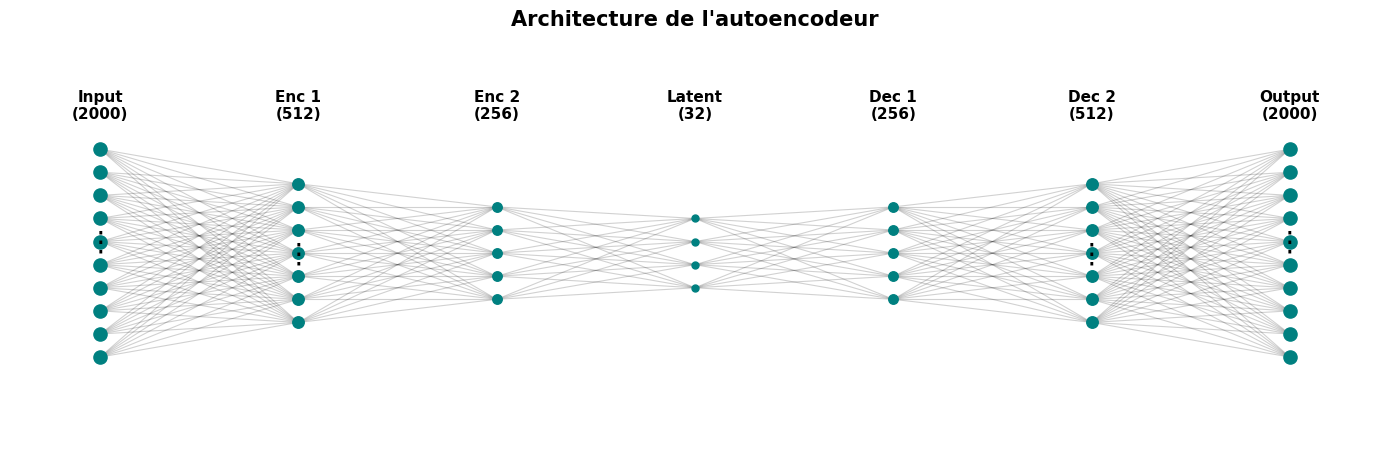

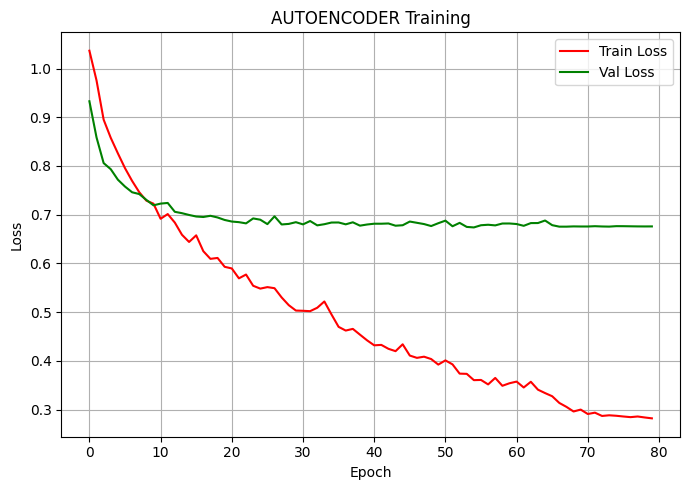

2026-01-13 22:29:56.230385: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


Shape de l'output: (452, 2000)
Données encodées: (452, 2000) → (452, 32)
Données encodées: (194, 2000) → (194, 32)
Encoder sauvegardé: models/rnaseq_tuning_encoder.keras
Autoencoder sauvegardé: models/rnaseq_tuning_autoencoder.keras

Bilan Network

Input dimension: 2000
Seed: 42

Encoder: 32 dimensions latentes



Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 2000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_dense_0 (Dense)             │ (None, 512)            │     1,024,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_dropout_0 (Dropout)         │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_dense_1 (Dense)             │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_dropout_1 (Dropout)         │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoding (Dense)                │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_dense_0 (Dense)             │ (None, 256)            │         8,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_dropout_0 (Dropout)         │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_dense_1 (Dense)             │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_dropout_1 (Dropout)         │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 2000)           │     1,026,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,990,290 (26.67 MB)

 Trainable params: 2,330,096 (8.89 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,660,194 (17.78 MB)

None
Données encodées: (194, 32)

Target de prédiction: PAM50



In [20]:
"""Initialisation de la classe"""
network = RNASeqNetwork(input_dim=X_train.shape[1], seed=seed)

"""Autoencoder and latent space encoding"""

print(f"Target de prédiction: {Target}\n")
network.build_autoencoder(
    encoding_dim=32,
    activation="relu",
    hidden_layers=[512, 256],
    dropout_rate=0.1
)
network.train_autoencoder(
    X_train=X_train,
    epochs=300,
    batch_size=16,
    validation_split=0.2,
    learning_rate=5e-4
)
network.plot_ae_networkx(layer_names=("Input", "Enc 1", "Enc 2", "Latent", "Dec 1", "Dec 2", "Output"),
    max_nodes_per_layer=10,
    title="Architecture de l'autoencodeur")

network.plot_training_history()

X_train_reconstructed = network.autoencoder.predict(X_train, verbose=0)
X_test_reconstructed = network.autoencoder.predict(X_test, verbose=0)
print(f"Shape de l'output: {X_train_reconstructed.shape}")

X_train_encoded=network.encode_data(X_train)
X_test_encoded=network.encode_data(X_test)
"""Sauvegarde et Bilan"""
network.save_models('models/rnaseq_tuning')
network.summary()
print(f"\nTarget de prédiction: {Target}\n")

# Tuning of hyperparameters

We use this to find the optimal parameters of the autoencodeur and MLP to ensure the best performance, while avoiding overfitting.  
These hyperparameters are then used to analyse the dataset

In [ ]:
"""
HYPERPARAMETER TUNING
"""
import itertools
from datetime import datetime

param_grid = {
    'encoding_dim': [32, 64, 128],
    'hidden_layers': [
        [256, 128],
        [512, 256],
        [512, 256, 128],
        [1024, 512, 256]
    ],
    'dropout_rate': [0.1, 0.2, 0.3],
    'learning_rate': [1e-4, 5e-4, 1e-3],
    'batch_size': [32, 64]
}

keys = param_grid.keys()
combinations = [dict(zip(keys, v)) for v in itertools.product(*param_grid.values())]

print(f"Combinaisons possibles: {len(combinations)}")

results = []
for i, config in enumerate(combinations):
    print(f"\n{'='*60}")
    print(f"Config {i+1}/{len(combinations)}")
    print(f"{'='*60}")
    print(f"Params: {config}")
    
    try:
        # Créer un nouveau réseau
        net = RNASeqNetwork(input_dim=X_train.shape[1], seed=42)
        
        # Build autoencoder avec les params
        net.build_autoencoder(
            encoding_dim=config['encoding_dim'],
            hidden_layers=config['hidden_layers'],
            dropout_rate=config['dropout_rate'],
            activation='relu'
        )
        
        # Entraîner
        net.train_autoencoder(
            X_train=X_train,
            epochs=200,  # Réduit pour aller plus vite
            batch_size=config['batch_size'],
            validation_split=0.2,
            learning_rate=config['learning_rate'],
            verbose=0  # Pas de spam dans la console
        )
        
        # Récupérer les métriques finales
        train_loss = net.history['autoencoder'].history['loss'][-1]
        val_loss = net.history['autoencoder'].history['val_loss'][-1]
        best_epoch = len(net.history['autoencoder'].history['loss'])
        
        # Encoder et tester sur le MLP pour avoir une métrique de classification
        X_enc = net.encode_data(X_train)
        
        # MLP rapide pour validation
        net.build_mlp_classifier(
            n_classes=len(np.unique(Y_train)),
            hidden_layers=[32, 16],
            activation='relu',
            dropout_rate=0.2
        )
        
        net.train_mlp_classifier(
            y_train=Y_train,
            epochs=50,
            validation_split=0.2,
            learning_rate=1e-3,
            early_stop=True,
            verbose=0
        )
        
        mlp_val_acc = net.history['mlp'].history['val_accuracy'][-1]
        
        # Stocker les résultats
        result = {
            'config_id': i,
            'encoding_dim': config['encoding_dim'],
            'hidden_layers': str(config['hidden_layers']),
            'dropout_rate': config['dropout_rate'],
            'learning_rate': config['learning_rate'],
            'batch_size': config['batch_size'],
            'train_loss': train_loss,
            'val_loss': val_loss,
            'best_epoch': best_epoch,
            'mlp_val_accuracy': mlp_val_acc,
            'overfitting_gap': val_loss - train_loss,
            'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        }
        
        results.append(result)
        
        print(f"Val Loss: {val_loss:.4f} | MLP Val Acc: {mlp_val_acc:.4f}")
        
        # Sauvegarder les résultats après chaque config (au cas où crash)
        df_results = pd.DataFrame(results)
        df_results.to_csv('hyperparameter_tuning_results.csv', index=False)
        
    except Exception as e:
        print(f"Erreur avec config {i}: {e}")
        continue


print("Tuning terminé")
df_results = pd.DataFrame(results)
df_results = df_results.sort_values('mlp_val_accuracy', ascending=False)

print("\nSauvegardé dans: hyperparameter_tuning_results.csv")

# Meilleure config
best_config = df_results.iloc[0]
print(f"\nMilleure combinaison: (config_id={best_config['config_id']}):")
print(f"   Encoding dim: {best_config['encoding_dim']}")
print(f"   Hidden layers: {best_config['hidden_layers']}")
print(f"   Dropout: {best_config['dropout_rate']}")
print(f"   Learning rate: {best_config['learning_rate']}")
print(f"   Batch size: {best_config['batch_size']}")
print(f"   Val Loss: {best_config['val_loss']:.4f}")
print(f"   MLP Acc: {best_config['mlp_val_accuracy']:.4f}")

#### Debugging and general info

In [17]:
print(f"X_train_scaled shape: {X_train.shape}")
print(f"X_test_scaled shape: {X_test.shape}")

print(f"\nnetwork.input_dim: {network.input_dim}")
print("\nStatistiques du réseau pour X_train:\n")
print(f"Min: {X_train.min().min():.4f}")
print(f"Max: {X_train.max().max():.4f}")
print(f"Mean: {X_train.mean().mean():.4f}")
print(f"Std: {X_train.std().mean():.4f}")
print("\nStatistiques du réseau pour X_test:\n")
print(f"Min: {X_test.min().min():.4f}")
print(f"Max: {X_test.max().max():.4f}")
print(f"Mean: {X_test.mean().mean():.4f}")
print(f"Std: {X_test.std().mean():.4f}")
print("\nsi mean~0 et std~1, alors MSE et relu sont bien adaptés, sinon chercher autrement\n")
print("Verification des valeurs NaN ou Inf:\n")
print(f"NaN pour X_train: {X_train.isna().sum().sum()}")
print(f"NaN pour X_test: {X_test.isna().sum().sum()}")
print(f"Inf pour X_train: {np.isinf(X_train.values).sum()}")
print(f"Inf pour X_test: {np.isinf(X_test.values).sum()}")

X_train_scaled shape: (452, 2000)
X_test_scaled shape: (194, 2000)

network.input_dim: 2000

Statistiques du réseau pour X_train:

Min: -3.0247
Max: 25.3968
Mean: 0.0013
Std: 1.0087

Statistiques du réseau pour X_test:

Min: -2.8195
Max: 25.3848
Mean: -0.0030
Std: 0.9281

si mean~0 et std~1, alors MSE et relu sont bien adaptés, sinon chercher autrement

Verification des valeurs NaN ou Inf:

NaN pour X_train: 0
NaN pour X_test: 0
Inf pour X_train: 0
Inf pour X_test: 0


In [18]:
print(network.X_encoded.shape)
print(network.labels)
# Check class balance
unique, counts = np.unique(Y_train, return_counts=True)
for cls, count in zip(label_encoder.classes_, counts):
    print(f"{cls}: {count} ({100*count/len(Y_train):.1f}%)")

(194, 64)
None
Basal: 78 (17.3%)
Her2: 41 (9.1%)
LumA: 253 (56.0%)
LumB: 65 (14.4%)
Normal: 15 (3.3%)


Données encodées: (452, 2000) → (452, 32)
MLP construit: 32 → 32 → 16 → 5
Entraînement MLP (300 epochs max) avec callbacks
Epoch 1/300


2026-01-13 22:30:46.166547: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
/home/pedro/miniconda3/envs/keras_env/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.0997 - loss: 1.6781 - val_accuracy: 0.0220 - val_loss: 2.0331 - learning_rate: 5.0000e-04
Epoch 2/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0942 - loss: 1.6931 - val_accuracy: 0.0549 - val_loss: 1.9697 - learning_rate: 5.0000e-04
Epoch 3/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1330 - loss: 1.6546 - val_accuracy: 0.0879 - val_loss: 1.9122 - learning_rate: 5.0000e-04
Epoch 4/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1468 - loss: 1.6698 - val_accuracy: 0.1209 - val_loss: 1.8615 - learning_rate: 5.0000e-04
Epoch 5/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1524 - loss: 1.6230 - val_accuracy: 0.1648 - val_loss: 1.8160 - learning_rate: 5.0000e-04
Epoch 6/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1662 - loss: 1.6098 - val_accuracy: 0.1868 - val_loss: 1.7760 - learning_rate: 5.0000e-04
Epoch 7/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1801 - loss: 1.

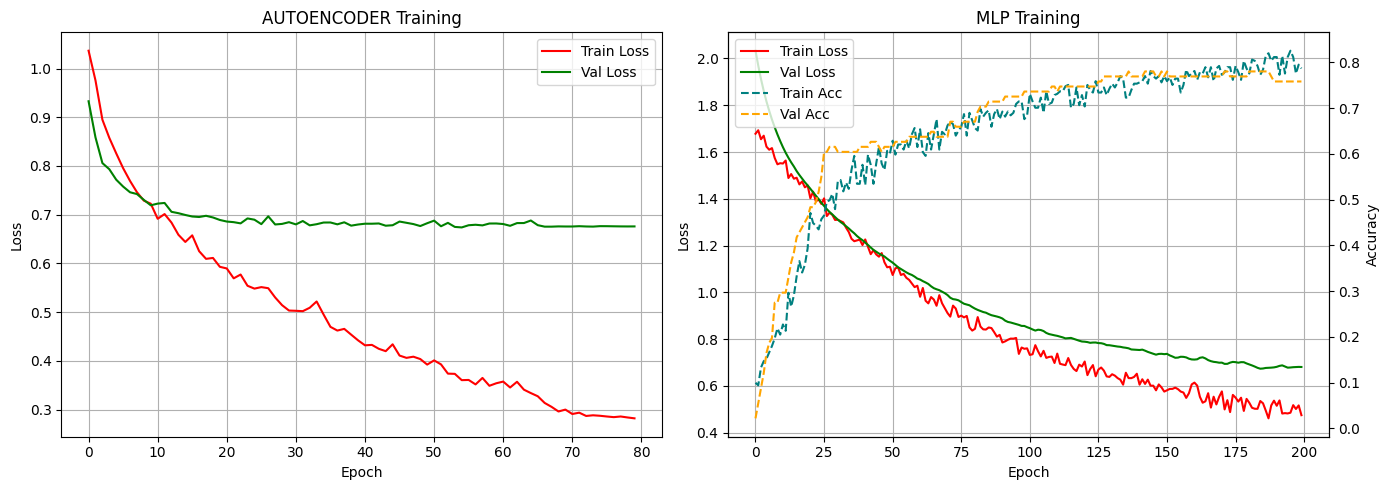


Bilan Network

Input dimension: 2000
Seed: 42

Encoder: 32 dimensions latentes



Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 2000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_dense_0 (Dense)             │ (None, 512)            │     1,024,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_dropout_0 (Dropout)         │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_dense_1 (Dense)             │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_dropout_1 (Dropout)         │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoding (Dense)                │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_dense_0 (Dense)             │ (None, 256)            │         8,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_dropout_0 (Dropout)         │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_dense_1 (Dense)             │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_dropout_1 (Dropout)         │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 2000)           │     1,026,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,990,290 (26.67 MB)

 Trainable params: 2,330,096 (8.89 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,660,194 (17.78 MB)

None
Données encodées: (452, 32)
MLP Classifier construit



Model: "mlp_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 5)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,009 (19.57 KB)

 Trainable params: 1,669 (6.52 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,340 (13.05 KB)

None


In [21]:
from sklearn.utils.class_weight import compute_class_weight

X_train_encoded = network.encode_data(X_train)

classes = np.unique(Y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=Y_train)
class_weight_dict = {int(cls): float(w) for cls, w in zip(classes, weights)}

network.build_mlp_classifier(
    n_classes=len(classes),
    hidden_layers=[32, 16],
    activation="sigmoid",
    dropout_rate=0.1
)

network.train_mlp_classifier(
    y_train=Y_train,
    epochs=300,
    validation_split=0.2,
    learning_rate=5e-4,
    early_stop=True,
    class_weight=class_weight_dict,
    verbose=1
)

network.plot_training_history()
network.summary()


Données encodées: (194, 2000) → (194, 32)
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


2026-01-13 18:49:28.015780: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


Test accuracy: 68.04%
              precision    recall  f1-score   support

       Basal       0.94      0.85      0.89        34
        Her2       0.53      0.94      0.68        17
        LumA       0.91      0.64      0.75       109
        LumB       0.43      0.46      0.45        28
      Normal       0.15      0.67      0.25         6

    accuracy                           0.68       194
   macro avg       0.59      0.71      0.60       194
weighted avg       0.79      0.68      0.71       194



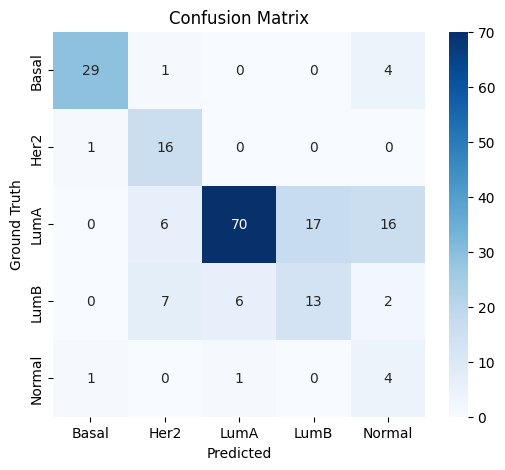

In [62]:
X_test_encoded = network.encode_data(X_test)
y_pred = network.mlp_classifier.predict(X_test_encoded).argmax(axis=1)

from sklearn.metrics import classification_report, confusion_matrix
print(f"Test accuracy: {np.mean(y_pred == Y_test)*100:.2f}%")
print(classification_report(Y_test, y_pred, target_names=label_encoder.classes_))

cm = confusion_matrix(Y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("Ground Truth")
plt.title("Confusion Matrix")
plt.show()

In [21]:
print(np.unique(metadata_cols))

['Final Pathology' 'PAM50' 'ProliferationScore' 'TumorPurity']


2026-01-13 22:54:51.133610: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
/home/pedro/miniconda3/envs/keras_env/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Shape reconstruction train: (390, 2000)
Shape reconstruction test: (168, 2000)


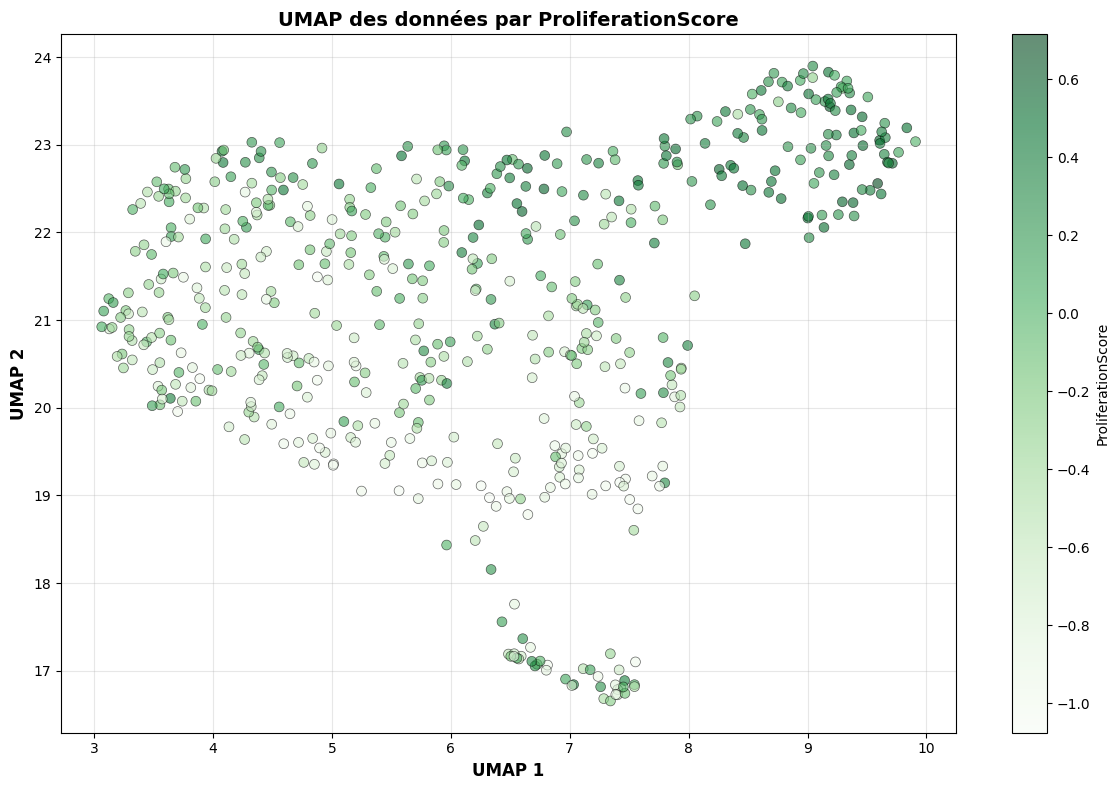


Distribution des classes pour ProliferationScore:
ProliferationScore
-0.851031    1
 0.339438    1
 0.035249    1
-0.304626    1
 0.125044    1
            ..
 0.239921    1
 0.339610    1
-0.704393    1
-0.204981    1
-0.108347    1
Name: count, Length: 558, dtype: int64


In [37]:
target_column = "ProliferationScore" 

X_train_reconstructed = network.autoencoder.predict(X_train, verbose=0)
X_test_reconstructed = network.autoencoder.predict(X_test, verbose=0)
print(f"Shape reconstruction train: {X_train_reconstructed.shape}")
print(f"Shape reconstruction test: {X_test_reconstructed.shape}")

y_train_labels = test_matrix_with_meta.loc[X_train.index, target_column]
y_test_labels = test_matrix_with_meta.loc[X_test.index, target_column]


X_combined = np.vstack([X_train_reconstructed, X_test_reconstructed])
y_combined = pd.concat([y_train_labels, y_test_labels])


umap_model = UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)
X_umap = umap_model.fit_transform(X_combined)


plt.figure(figsize=(12, 8))
if y_combined.dtype == 'object':
    label_encoder_viz = LabelEncoder()
    y_numeric = label_encoder_viz.fit_transform(y_combined)
    categories = label_encoder_viz.classes_
else:
    y_numeric = y_combined
    categories = np.unique(y_combined)
scatter = plt.scatter(X_umap[:, 0], X_umap[:, 1], c=y_numeric,cmap='Greens', alpha=0.6, edgecolors='black', linewidth=0.5,s=50)

plt.xlabel('UMAP 1', fontsize=12, fontweight='bold')
plt.ylabel('UMAP 2', fontsize=12, fontweight='bold')
plt.title(f'UMAP des données par {target_column}', 
        fontsize=14, fontweight='bold')

# Légende
if y_combined.dtype == 'object':
    handles = []
    for i, cat in enumerate(categories):
        color = scatter.cmap(scatter.norm(i))
        handles.append(plt.Line2D([0], [0], marker='o', color='w', 
            markerfacecolor=color, markersize=10, 
            label=cat, markeredgecolor='black'))
    plt.legend(handles=handles, title=target_column, loc='best', framealpha=0.9)
else:
    plt.colorbar(scatter, label=target_column)

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nDistribution des classes pour {target_column}:")
print(y_combined.value_counts())

## Test de la reproductibilité entre chaque run

In [23]:
results = []

runs=3  #nombre de runs a tester

for i in range(runs):
    random.seed(42)
    np.random.seed(42)
    tf.random.set_seed(42)
    
    # Re-créer le réseau
    net_test = RNASeqNetwork(input_dim=X_train_scaled.shape[1], seed=42)
    net_test.build_autoencoder(encoding_dim=64, hidden_layers=[1024, 512], dropout_rate=0.2)
    net_test.train_autoencoder(X_train, epochs=10, batch_size=32, verbose=0)
    
    X_enc = net_test.encode_data(X_train)
    results.append(X_enc[:5, :3])  # Premiers encodages
    
# Comparer
print("Run 1:\n", results[0])
print("\nRun 2:\n", results[1])
print("\nRun 3:\n", results[2])
print("\nIdentiques?", np.allclose(results[0], results[1]) and np.allclose(results[1], results[2]))
print("\nSi les résultats sont identiques, on valide la reproductibilité entre chaque run")

Network (input_dim=2000, seed=42)
Autoencoder construit: 2000 → 1024 → 512 → 64
Entraînement autoencoder (10 epochs max, batch=32)


2026-01-13 13:13:36.432061: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


Restoring model weights from the end of the best epoch: 8.
Entraînement terminé (loss finale: 0.7611)


2026-01-13 13:13:48.529032: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


Données encodées: (452, 2000) → (452, 64)
Network (input_dim=2000, seed=42)
Autoencoder construit: 2000 → 1024 → 512 → 64
Entraînement autoencoder (10 epochs max, batch=32)
Restoring model weights from the end of the best epoch: 8.
Entraînement terminé (loss finale: 0.7611)


2026-01-13 13:14:00.415086: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


Données encodées: (452, 2000) → (452, 64)
Network (input_dim=2000, seed=42)
Autoencoder construit: 2000 → 1024 → 512 → 64
Entraînement autoencoder (10 epochs max, batch=32)
Restoring model weights from the end of the best epoch: 8.
Entraînement terminé (loss finale: 0.7611)


2026-01-13 13:14:14.087900: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


Données encodées: (452, 2000) → (452, 64)
Run 1:
 [[ 0.       13.172939  0.      ]
 [ 0.        9.132366  0.      ]
 [ 0.        0.        0.      ]
 [ 0.        0.        0.      ]
 [ 0.        0.        0.      ]]

Run 2:
 [[ 0.       13.172939  0.      ]
 [ 0.        9.132366  0.      ]
 [ 0.        0.        0.      ]
 [ 0.        0.        0.      ]
 [ 0.        0.        0.      ]]

Run 3:
 [[ 0.       13.172939  0.      ]
 [ 0.        9.132366  0.      ]
 [ 0.        0.        0.      ]
 [ 0.        0.        0.      ]
 [ 0.        0.        0.      ]]

Identiques? True

Si les résultats sont identiques, on valide la reproductibilité entre chaque run
